# Adaptive Cruise Control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]'

In [3]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns

## Setup Problem (dynamics, environment and CBF)

Dynamics of the Adaptive Cruise Control problem (control affine), in the format of `cbf_opt`

`ACC_JNP_Dynamics` is required for usage with `hj_reachability` module

In [4]:
class ACCDynamics(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1 / self.mass 
        return B


class ACCJNPDynamics(ACCDynamics):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

In [5]:
class ACC_Classic(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]

        super().__init__(params, **kwargs)
    
    def state_jacobian(self, state, control, time=0.):
        return np.array([[0, 1, 0], [0, -1 / self.mass * (self.f1 + 2 * self.f2 * state[1]), 0], [0, -1, 0]])

    def open_loop_dynamics(self, state, time=0.0):
        return np.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return np.expand_dims(np.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return np.expand_dims(np.zeros(3), axis=-1)    
    
class ACC_JNP_extended(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = jnp.repeat(jnp.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J = J.at[..., 0, 1].set(1)
        
        J = J.at[..., 1, 1].set(-1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1]))
        J = J.at[..., 2, 1].set(-1)
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = jnp.zeros_like(state)
        f = f.at[..., 0].set(state[..., 1])
        f = f.at[..., 1].set(-1 / self.mass * self.rolling_resistance(state))
        f = f.at[..., 2].set(self.v0 - state[..., 1])
        return f

    def control_matrix(self, state, time=0.):
        B = jnp.repeat(jnp.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B = B.at[..., 1, 0].set(1 / self.mass)
        return B

Setting up the Dynamics with specific parameter instantiation

In [6]:
params = dict()
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACCDynamics(params)
acc_jnp = ACCJNPDynamics(params)
acc_classic = ACC_Classic(params)
acc_jnp_extended = ACC_JNP_extended(params)

In [7]:
state = np.random.rand(3)
time = np.random.rand(1)
control = np.random.rand(1)
print(acc_jnp(state, control, time))
print(acc_jnp_extended(state, control, time))

[ 9.7385979e-01 -2.6748134e-03  1.3026140e+01]
[ 9.7385979e-01 -2.6748134e-03  1.3026140e+01]


## Initial Control Barrier Function
Below is a candidate CBF (safe, but overly conservative) for the problem. This is the optimal CBF when neglecting friction (but it does account for limited actuation).

In [8]:
class ACCCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.Th = params["Th"]
        self.cd = params["cd"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

Setting up the CBF with specific parameter instantiation

In [9]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACCCBF(acc, cbf_params)
acc_jnp_extended_cbf = ACCCBF(acc_jnp_extended, cbf_params)

In [10]:
acc_classic_cbf = ACCCBF(acc_classic, cbf_params)
acc_jnp_cbf = ACCCBF(acc_jnp, cbf_params)

Setting maximal and minimal control effort

In [11]:
umax = np.array([cbf_params['cd'] * params['mass'] * params['g']])
umin = -umax

### Environment

In [12]:
dyn_reachability_jnp = refine_cbfs.HJControlAffineDynamics(acc_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))
dyn_reachability = refine_cbfs.HJControlAffineDynamics(acc, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))
dyn_reachability_jnp_extended = refine_cbfs.HJControlAffineDynamics(acc_jnp_extended, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))
dyn_reachability_classic = refine_cbfs.HJControlAffineDynamics(acc_classic, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))


low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([1e3, 40., 100.])
nbr_pts = (51, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)
grid_np = refine_cbfs.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

In [13]:
obstacle = grid.states[..., 2] - acc_cbf.Th * grid.states[..., 1]

## Refining the CBF using Dynamic Programming

In [14]:
acc_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc, dict(), grid=grid)
acc_classic_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc_classic, dict(), grid=grid)
acc_jnp_extended_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc_jnp_extended, dict(), grid=grid)
acc_jnp_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc_jnp, dict(), grid=grid)

acc_tabular_cbf.tabularize_cbf(acc_cbf)
acc_classic_tabular_cbf.tabularize_cbf(acc_classic_cbf)
acc_jnp_extended_tabular_cbf.tabularize_cbf(acc_jnp_extended_cbf)
acc_jnp_tabular_cbf.tabularize_cbf(acc_jnp_cbf)

In [15]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))
init_value = acc_jnp_extended_tabular_cbf.vf_table

In [16]:
type(init_value)

numpy.ndarray

In [17]:
dyn_reachability

In [18]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values_hjr = hj.solve(solver_settings, dyn_reachability_jnp, grid, times, obstacle)

100%|##########| 20.0000/20.0 [01:40<00:00,  5.01s/sim_s]


In [19]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability_jnp, grid, times, init_value)

100%|##########| 20.0000/20.0 [01:36<00:00,  4.82s/sim_s]


In [20]:
# time = 0.
# target_time = -20.0
# times = jnp.linspace(time, target_time, 101)
# target_values_extended = hj.solve(solver_settings, dyn_reachability_jnp_extended, grid, times, init_value)

In [21]:
refined_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
refined_cbf_classic = refine_cbfs.TabularControlAffineCBF(acc_classic, grid=grid_np)
refined_cbf_jnp_extended = refine_cbfs.TabularControlAffineCBF(acc_jnp_extended, grid=grid)
refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(acc_jnp, grid=grid)

refined_cbf.vf_table = np.array(target_values[-1])
refined_cbf_classic.vf_table = np.array(target_values[-1])
refined_cbf_jnp_extended.vf_table = target_values[-1]
refined_cbf_jnp.vf_table = target_values[-1]



################################
timestamp = 2
partial_hjr_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
partial_hjr_cbf.vf_table = np.array(target_values_hjr[timestamp])

partial_refined_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid_np)
partial_refined_cbf.vf_table = np.array(target_values[timestamp])

## Running an experiment (Same as the Paper)

In [22]:
x0 = np.array([[0, 25, 90]])
n_sims_per_start = 1
t_sim = 20

In [23]:
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment

### Setting up the nominal controller

We simply tune a proporitional controller for the nominal controller

In [24]:
desired_vel = 24
feedback_gain = 200
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-feedback_gain * (x[..., 1] - desired_vel), umin, umax))
nominal_policy_jnp = lambda x, t: jnp.atleast_1d(jnp.clip(-feedback_gain * (x[..., 1] - desired_vel), umin, umax))

### Setting up the safety filter

In [25]:
alpha = lambda x: 5 * x

acc_asif = ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)
acc_asif_ws = ControlAffineASIF(acc, refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)

acc_partial_hjr_asif = ControlAffineASIF(acc, partial_hjr_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)
acc_partial_asif_ws = ControlAffineASIF(acc, partial_refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)

# acc_asif_ws_jnp = ControlAffineASIF(acc_jnp_extended, refined_cbf_jnp_extended, alpha=alpha, nominal_policy=nominal_policy_jnp)

# Visualizations for paper + demo + videos

In [38]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as anim

### Safe set visualization

In [27]:
# def render_frame(i, colorbar=False):
#     global cont
#     for c in cont.collections:
#         c.remove()
#     timestamp.set_text("Iteration = {}".format(i))
#     cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[i][0].T, levels=[0], colors=gen_colors[2])

# value_function = target_values_hjr
# filename=os.path.join(os.getcwd(), "acc/vf_time_hjr.mp4")
# proxy = [] 

# fig, ax = plt.subplots(figsize=(16, 9))
# blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
# gen_colors = sns.color_palette("colorblind", 9).as_hex()
# alt_colors = sns.color_palette("pastel", 9).as_hex()

# cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle[0].T, levels=[-100, 0], colors=alt_colors[3], alpha=0.8)
# proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]

# cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0, 200], colors=alt_colors[2], alpha=0.3)


# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[1])
# # proxy += [plt.Rectangle((0,0),1,1,ec = 'b', fc='white') 
# #         for pc in cs.collections]

# proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[1], fc='white', lw=5)
#         for pc in cont.collections]

# timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[2])
# proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[2], fc='white', lw=5)
#         for pc in cont.collections]
# # cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0], colors='orange')
# # proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
# #         for pc in cs.collections]
# ax.grid()

# proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
#         for pc in cs.collections]

# ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\mathcal{S}^*$"], loc='center', bbox_to_anchor=(0.5, 0.1), ncol=4, columnspacing=1.5, handletextpad=0.4)

# ax.set_ylabel("Distance between vehicles ($z$) [m]")
# ax.set_xlabel("Ego velocity ($v$) [m/s]")


# # ax.set_title("Ames 2016", fontsize=24)
# # fig.suptitle("Adaptive Cruise Control")
# render_frame(0, False)
# animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0] * 6 // 20, interval=100)
# # animation.save(filename, writer='ffmpeg')

### Online: Safety filter visualization

In [28]:
x0 = np.array([0, 30, 90])
experiment_paper = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [77]:
paper_results = experiment_paper.run(acc, {'nominal': nominal_policy, 'Analytical': acc_asif, 'Refined': acc_asif_ws, 'partial_hjr': acc_partial_hjr_asif, 'partial_cbf': acc_partial_asif_ws})

Controller rollout: 100%|██████████| 2000/2000 [00:14<00:00, 139.76it/s]


In [142]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))


In [143]:
sns.color_palette(chosen_colors)

[(0.5, 0.5, 0.5),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.1, 0.1, 0.1),
 (0.7, 0.7, 0.7)]

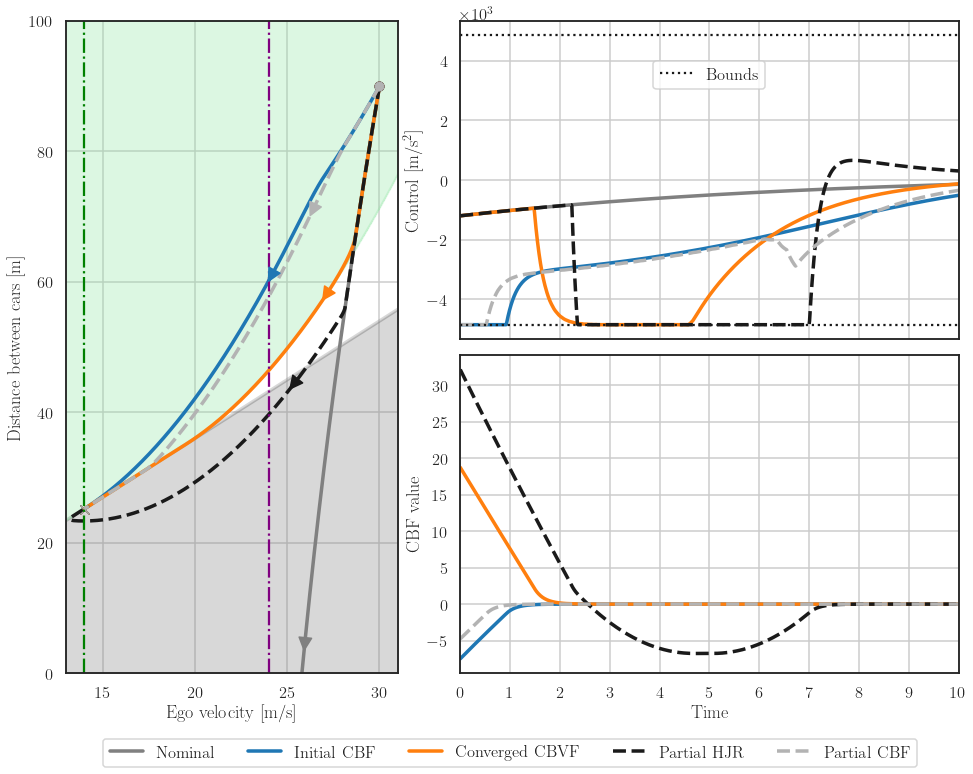

In [144]:
ts_experiment_addt = TimeSeriesExperiment('acc_example', x_indices=[], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment_addt = StateSpaceExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

# fig, axs = plt.subplots(3, 1, sharex=False, figsize=(16, 12))
alt_colors = sns.color_palette("pastel", 9).as_hex()
# plt.subplots_adjust(hspace=0.0)
#make outer gridspec
fig = plt.figure(figsize=(16, 12))
colors = sns.color_palette("tab10")
outer = gridspec.GridSpec(1, 2, width_ratios= [2, 3], figure=fig, wspace=.15) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .05)
axs = []
for cell in gs1:
    axs += [plt.subplot(cell)]

for cell in gs2:
    axs += [plt.subplot(cell)]
    
axs = np.array(axs)
x = np.linspace(13, 31, 1000)
axs[0].fill_between(x, acc_cbf.Th * x, alpha=0.3, color='grey')
axs[0].plot(x, acc_cbf.Th * x, color='grey', alpha=.3)

axs[0].contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[-1][0].T, levels=[0, 200], alpha=0.3, colors=alt_colors[2])
axs[0].contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[-1][0].T, levels=[0], colors=alt_colors[2], alpha=.3)

fig_handle_ss = ss_experiment_addt.plot(acc, paper_results, extra_measurements=['vf'], ax=axs[0], 
                                        color=chosen_colors, linestyles=['-', '-', '-', '--', '--'])
fig_handle_ts = ts_experiment_addt.plot(acc, paper_results, extra_measurements=['vf'], axs=axs[1:], 
                                        colors=chosen_colors, linestyles=['-', '-', '-', '--', '--'])
# axs[1].get_shared_x_axes().remove(axs[0])
plt.rcParams["font.family"] = "serif"
axs[1].get_shared_x_axes().join(axs[1], axs[2])
axs[0].set_xlabel("Ego velocity [m/s]")
axs[0].set_ylabel("Distance between cars [m]")
for ax in axs:
    for line in ax.lines:
        line.set_linewidth(3.5)

ts = axs[1].lines[0]._x

axs[1].set_ylabel("Control [m/s$^2$]")

axs[1].set_xticklabels([])

axs[0].set_ylim([0, 100])
axs[0].set_xlim([13, 31])

leg = axs[1].legend(["Nominal", "Initial CBF", "Converged CBVF", "Partial HJR", "Partial CBF"], ncol=5, loc='center', bbox_to_anchor=(0.1, -1.3))    
axs[1].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
axs[1].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, .9))

# from matplotlib.ticker import ScalarFormatter
# axs[1].yaxis.set_major_formatter(ScalarFormatter('%.0f'))
# axs[1].yaxis.get_major_formatter().set_scientific(True)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# axs[1].yaxis.set_major_form
# axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].set_ylabel("CBF value")
axs[2].set_xlabel("Time")

axs[0].vlines(24, 0, 100, color='purple', linestyle='-.')
axs[0].vlines(14, 0, 100, color='green', linestyle='-.')

# dx = 10/72.; dy = 0/72. 
# offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
# for label in axs[1].yaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)

axs[1].add_artist(leg)
axs[2].set_xticks(np.arange(0,11))
axs[1].set_xticks(np.arange(0,11))
for ax in axs:
    ax.grid(which='both')
for ax in axs[1:]:
    ax.set_xlim(ts[0], 10)
    
# axs[2].yaxis.set_label_coords(-0.065, 0.5)

# plt.subplot_tool()

In [ ]:
ts_experiment = TimeSeriesExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 12))
fig_handle = ts_experiment.plot(acc, paper_results, extra_measurements=['vf'], axs=axs)
axs[0].set_ylabel("Ego Velocity")
ts = axs[0].lines[0]._x

axs[0].plot(ts, desired_vel * np.ones_like(ts), ':k', label='Desired velocity')
axs[0].plot(ts, params["v0"] * np.ones_like(ts), ':m', label='Lead vehicle velocity')
axs[0].set_ylim(0, 30)
axs[0].legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.15))



axs[2].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
axs[2].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
axs[2].legend()
axs[2].set_ylabel("Control (Acc)")

axs[3].set_ylabel("CBF value")
axs[3].set_xlabel("Time")
ax.set_xticks([0, np.pi, 2 * np.pi, 3 * np.pi, 4 * np.pi, 5 * np.pi])

for i in range(5):
    axs[1].plot(ts, axs[1].lines[i]._x - acc_cbf.Th * axs[0].lines[i]._y)
    axs[1].lines[i+5].set_color(axs[1].lines[i].get_color())
for i in range(5):
    axs[1].lines.pop(0)  

for ax in axs:
    ax.grid()
#     ax.lines[3].set_color(ax.lines[1].get_color())
#     ax.lines[4].set_color(ax.lines[2].get_color())
#     ax.lines[3].set_linestyle('--')
#     ax.lines[4].set_linestyle('--')
#     # axi.set_xlabel("Time")
#     # axi.set_ylabel("Value")
#     ax.yaxis.set_label_coords(-0.04, 0.5)
#     # ax.set_xlim([ts[0], 10])
leg = axs[1].legend(["Nominal", "Initial CBF", "Converged CBVF", "Partial HJR", "Partial CBF"], ncol=5) #, loc='center', bbox_to_anchor=(0.5, -1.75))    
axs[1].add_artist(leg)

axs[1].plot(ts, np.ones_like(ts) * 0, ':k', label='__nolegend__')

# # fig.tight_layout()
# fig.subplots_adjust(wspace=-0.05)
# # fig.savefig("acc/acc_highway_asif.pdf", bbox_inches='tight')

In [ ]:
fig_handle[0][1].axes

In [ ]:
ss_experiment = StateSpaceExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
fig_handle = ss_experiment.plot(acc, paper_results)

ax = fig_handle[0][1].axes[0]
x = np.linspace(14, 30, 1000)
plt.plot(x, acc_cbf.Th * x, ':k')
plt.ylim(0, 50)
plt.legend(ax.lines[::3], ["Nominal", "Initial CBF", "Converged CBVF", "Partial HJR", "Partial CBF"], ncol=5)

In [ ]:
axs[1].lines